# How good is the food?

*Rafael Cardenas* 

*Disclaimer: This project is still under construction, at this date (19.07.20) the classification algorithm is being fine tunned to increase its performance*

### Project Outline


1. [Problem background and business value](#Problem_Backgound)
2. [Objectives and problem statement](#Objectives)
3. [EDA](#EDA)
4. Methodology
5. Algorithm
6. Conclusions and next Steps

# Background
<a id='Problem_Backgound'><a/>

Sentiment Analysis has raised in parallel with the ammount of opinions on the web. Part of a broader field known as opinion mining, in the early 2000's gained popularity as businesses started to receive more and more feedback for their products in the form of comments.
As data volumes began to increase in size, methods to extract information were developed, sentiment analysis is still considered as a robust one to quantify opinions of the masses.

Fast forward to more recent times, sentiment analysis has extended farther than product reviews; now ranging from *brand perception* to opinion mining in sensible topics such as the elections.

##### Business Value:
At the end of the day, data **science in a company serves the ultimate goal of a business: Profit generation.** Sentiment Analysis has a broad range of applications in the real world. Successful companies mine opinions of a specific brand/product from several sources to quickly know what is popular opinion of the product/brand and identify the possible reasons; with that, companies could make better decisions in difficult times.
In this same vein, businesses can identify which are the most important factors that lead the costumer to incline towards a positive or negative opinion and based on that, make the pertinent moves.


# Objectives and problem statement
<a id='Objectives'></a>

This project has been done from a didactical point of view, approaching the problem with the combination of already existing resources and my own initiative. That being said, I did set specific goals and success metrics for this project:

* No libraries *(NLTK, SpaCy)* NLP pipeline: Self imposed restriction to manually implement text preparation and feature extraction.
* At least 85% accuracy on classification, taking as benchmark papers on Sentiment Analysis **([Pang, et al. 2002](https://www.aclweb.org/anthology/W02-1011/) & [Potts, et al. 2011](https://web.stanford.edu/~cgpotts/papers/potts-salt20-negation.pdf))**
* Deploy the model. ML models that does not go beyond a notebook provide no value to the business, for a model to be useful, an API should be available

##### Problem Statement

The questions that are going to be answer through this analysis.

1. What makes a good/bad review?
2. In which aspects should restaurants improbe to gain/mantain customers?
3. Can we identify fake reviews? i.e reviews written by owners

# Exploratory Data Analysis
<a id='EDA'><a/>

In order to keep the focus of this project on the analysis part of the pipeline, I used the [*Yelp Dataset*](https://www.yelp.com/dataset/download) provided by Yelp.
This part of the documentation focuses on the initial analysis of the data to make myself familiar with the data and make my first assumptions and paths that I could take towards the analysis.

#### Starting with the preprocessing...

In [786]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import re
from wordcloud import WordCloud, STOPWORDS

##### Load the 'business' dataset

In [569]:
df2 = pd.read_json("yelp_academic_dataset_business.json", chunksize = 1000, lines = True)
drop_cols = ['address', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open','attributes', 'hours']

##### Load the reviews dataset
Merge using ONLY the 'Restaurants' category

In [570]:
reviews_raw = pd.read_json("yelp_academic_dataset_review.json", chunksize=100000, lines = True)
drop_cols = ['review_id', 'user_id','useful', 'funny', 'cool', 'date']

Using merge instead of join because we want to join in another column other than the index

In [571]:
a = 0
for chunk in reviews_raw:
    a += 1
    reviews = chunk.drop(drop_cols, axis = 1)
    data = restaurants.merge(reviews, left_on = 'business_id', right_on = 'business_id',how = 'inner')
    if a == 1:
        break

##### The 'text' column is the data to be preprocessed
(delete this)


To be done: 
* Delete all number 3 i.e neutral 
* Same number of positive as negatives
* Shuffle the data

In [572]:
data.head(2)

,business_id,name,city,categories,stars,text
0,pQeaRpvuhoEqudo3uymHIQ,The Empanadas House,Champaign,"Ethnic Food, Food Trucks, Specialty Food, Impo...",5,I love the empanadas from the Empanadas House!...
1,CsLQLiRoafpJPJSkNX2h5Q,Middle East Deli,Charlotte,"Food, Restaurants, Grocery, Middle Eastern",3,"Definitely under new management, and the dinin..."


In [573]:
"There are: " + str(data.shape[0]) + " reviews on the data set"

'There are: 66698 reviews on the data set'

Text(0.5, 1.0, 'Number of reviews by stars')

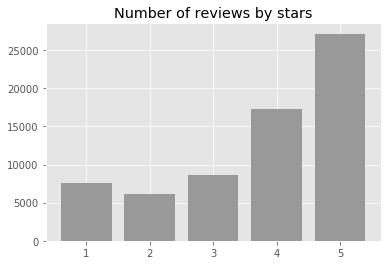

In [574]:
data = data.loc[:, ['name', 'stars', 'text']]
x = (data['stars'].value_counts()).index
y = (data['stars'].value_counts()).values
_ = plt.bar(x, y, color = '#999999')
plt.title("Number of reviews by stars")

**As we can see, the reviews are imbalanced, biased towards positive reviews**

Reviews with "1" and "2" stars fall into the negative (0) category, "4" and "5" in to the positive (1), but as we just saw, there are many more positive revies than negartive, thus, we use "3 stars" as negative (0) to augment the data and  balance the classes


In [692]:
def balance_sample(data, no_samples):
    neg_half = list((data[data['stars'] <=3]).index)
    neg_half = neg_half[:no_samples]
    pos_half = list(set(range(data.shape[0])) - set(neg_half))
    pos_half = pos_half[0:len(neg_half)]
    pos_half.extend(neg_half)
    dropper = list(set(range(data.shape[0])) - set(pos_half))
    data.drop(index = dropper, inplace = True)
    data['Sentiment'] = data['stars'].apply(lambda x: 1 if x > 3 else 0)  

#### For demonstration purposes, only 2000 samples of each class  are selected

In [575]:
balance_sample(data, 2000)

In [577]:
data.head()

,name,stars,text,Sentiment
0,The Empanadas House,5,I love the empanadas from the Empanadas House!...,1
1,Middle East Deli,3,"Definitely under new management, and the dinin...",0
2,Middle East Deli,3,I will also agree that this place has great fo...,0
3,Banzai Sushi,4,Been coming here since I was in grade 9 so abo...,1
4,Wetzel's Pretzels,5,Love Wetzel's pretzels! I always get them when...,1


##### Limiting data size
We use the previous function to balance the classes in terms of label and to reduce the number of samples that are going to be processed in the following steps. This was introduced to control the size of the data because of computational limitations. In this case we select 2000

Text(0.5, 1.0, 'Number of reviews by class')

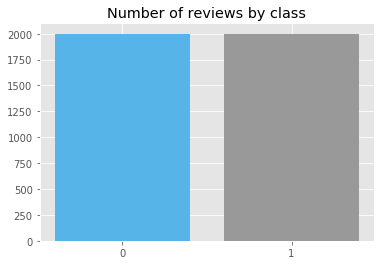

In [578]:
x = (data['Sentiment'].value_counts()).index
y = (data['Sentiment'].value_counts()).values
_ = plt.bar(x, y, color=['#999999','#56B4E9'])
plt.xticks([0,1])
plt.title("Number of reviews by class")

### -------------------------------------------------------------------------------------

### NLP pipeline
*Image Source: SpaCy*

![NLP pipeline](./Images/NLP_pipeline.png "Source: SpaCy")

As the image above explains, the first natural step for NLP pipeline is the tokenizer, that is the conversion of words into any more manageable form, tipically it is done simply separating words by blank space.
This tokenizer can be done with NLTK, in the following cells, a Prove of Concept (PoC) of the NLTK Tokenizer is done.
Once the words are converted into single "units" further processing such as *Bag of Words* can be implemented

### PoC for NLTK
*Used as starting point for self implemented tokenizer*

In [580]:
raw2 = data['text'][0]
raw2

"I love the empanadas from the Empanadas House! They're authentic Argentine empanadas and they are delicious! If you have a sweet tooth try the Dulce de Leche with Walnuts!"

In [581]:
from nltk.probability import FreqDist
counter = FreqDist()

In [582]:
tokenizer = []
a = 0
for i in raw2:
    words = i.lower()
    words = words.split()
    for word in words:
        a += 1
        counter[word] += 1
        if word not in tokenizer:
            tokenizer.append(word)
len(tokenizer)
tokenizer
words = raw2.split()
for word in words:
    a += 1
len(words)

29

**NLTK tokenizer gives would give this result**

In [584]:
print(words)

['I', 'love', 'the', 'empanadas', 'from', 'the', 'Empanadas', 'House!', "They're", 'authentic', 'Argentine', 'empanadas', 'and', 'they', 'are', 'delicious!', 'If', 'you', 'have', 'a', 'sweet', 'tooth', 'try', 'the', 'Dulce', 'de', 'Leche', 'with', 'Walnuts!']


##### NLTK also has an out-of-the-box counter that can be used to spot the most common words in the corpus

In [17]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [585]:
#out of the box tokenizer and counter
from nltk.probability import FreqDist
counter = FreqDist()
tokens_nltk = word_tokenize(raw2)

tokenizer = []
for word in tokens_nltk:
    counter[word.lower()] += 1

counter.most_common(2)

[('the', 3), ('empanadas', 3)]

With this example is clear the existence of **Stop words**. Common words in the language that does not have semantical value but only serve as connectors or to round up the meaning of an idea. The word: *the* is one of the most common stop words in english

**Other commands of NLTK**

```Python
counter.B() #is the number of unique words
counter.N #is the total number of words
set(stopwords.words("english")) #to display the dictionary of stop words by NLTK
```

### Negation tagging

When dealing with sentiments, sometimes only tokenizing is not enough to capture the relations of the words on the sentence. Specifically, under a negation scope, to capture the semantic value that provide negation expresions, the following method was proposed by [Das and Chen (2001)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.202.6418&rep=rep1&type=pdf) and [Pang et al. (2002)](https://www.aclweb.org/anthology/W02-1011/).
The reasoning is the following.

Suppose we have the following sentence we want to tokenize

"I did not like the movie that much because of the music, however, the casting was good enough"

With the *Sentiment Aware Toekenizer*, the resulting tokens would be:
[I, did, not, like_NOT, the_NOT, movie_NOT, that_NOT, much_NOT, because_NOT, of_NOT, the_NOT, music_NOT, however, the, casting, was, good, enough]

This would take into account the negation effect over the sentence until the first punctuation mark. i.e  **^[.:;!?]$** (in regex)

### Negation tagging implementation

In [674]:
def pesimist(text):
    """
    Function that applies the negation tagging to the string of text passed. Based on Das and Che, 2001 and
    Pang, L. et al. (2002)
    """
    x = str(text) + "."
    x = x.split()
    hasta = 0
    desde = 0
    c = 0
    j = 0
    passer = False
    for k in range(len(x)):
        #print(j)
        #print(k)
        #if not passer:
            #continue
        passer = True

        i = x[k]
        negation_string = r"""
        ^(?:never|no|nothing|nowhere|noone|none|not|
            havent|hasnt|hadnt|cant|couldnt|shouldnt|
            wont|wouldnt|but|doesnt|didnt|isnt|arent|aint
        )$|n't
        """
        #print("first")
        c +=1
        #match = re.search(r'\bthe\b',i)
        neg = re.compile(negation_string, re.VERBOSE | re.I | re.UNICODE)
        match = neg.findall(i)
        #print(i + "i")
        #print('desde', desde)
        #print(f'hasta menos desde es: {hasta - desde} y c es {c}')
        if c < (hasta - desde):
            continue
        if match:
            c = 0
            desde = k + 1
            #print(c - 1)
            #j = i
            jump = k
            for j in range(jump, 100):

                #print(j)
                try:
                    comma = re.search(r'[.:;!?]', x[j])
                    #print("second")
                    if comma:
                        hasta = j + 1
                        c += 1
                        
                        #this try to avoid error if there is no punctuation error before the phrase ends
                        try:
                            for i in range(desde, hasta):
                                repl = re.match(r'\w+', x[i])
                                x[i] = repl.group() + "_NOT"
                            
                            c = 0
                            break
                        except:
                            #print(' '.join(x))
                            c = 0
                            break
                except:
                    pass
        if match:
            continue



                #continue


            #else:
                #continue
            #break
    xx = ' '.join(x)
    return xx

## Tokenizer


#### Applying the previous function to the data frame

In [602]:
from Utils.happyfuntokenizing import Tokenizer

In [698]:
def tiktokens(raw_data):
    """
    Function that applies tokenization to the data frame based on happyfuntokenizing.Tokenizer
    ----------
    Atributes:
        raw_data: pandas dataframe
            Dataframe containing the reviews to be tokenized
    """
    raw_data["sample"] = raw_data.loc[:, "text"].apply(pesimist)
    tok = Tokenizer()
    raw_data["tokens"] = raw_data.loc[:, "sample"].apply(tok.tokenize)
    raw_data.reset_index(inplace = True)
    #print(raw_data["Sentiment"].value_counts())

In [691]:
#delete this
tok = Tokenizer()
tok.__dict__

{'preserve_case': False, 'all_in': False}

## Removing 'filler' words
Counting the most common words over all the corpora it is discovered that the most common ones are **stop words** which by nature, don't carry a lot of meaning from which the classifier could take advantage in its task. To reduce this noise and using heuristics, the first 15 words are going to be removed. 

In the following cells, the most common words are shown

In [696]:
data2 = data.copy()

In [699]:
tiktokens(data2)

In [701]:
reviews = data2['tokens'].to_numpy()
review1 = reviews[0]

In [703]:
#delete this cell
def most_common_words(raw_reviews, w_number):
    """
    Creates a list with the most 'w_number' (number) of words on the whole corpus
    ---------
    raw_reviews : all the column of the raw reviews
    w_number = number of most common words that wish to be extracted
    """
    
    commons = []
    for word in counting:
        commons.append(word[0])
        if len(commons) == w_number:
            break
    return commons, counter
#cc, count = most_common_words(reviews, 9)

## Bag of words

It is a dictionary that includes all the words present on the processed corpus, posteriorly used on the word-vector transformation process

The following function can restrict the number of words that are going to be in the bag of words, this allows to control the number of dimensions that the classifier is dealing with.

As is is shown in the latter graph, the frecuency of the words is very low relative to the first 500 words, this is an indication that the most frecuent words carry the most ammount of information, from there, other words add additional information to the classifier.

In [731]:
def restricted_corpus_builder(corpus_size, raw_reviews):
    """
    Create the bag of words with the first 'corpus_size' most common words present on the reviews
    -----------
    corpus_size : number of words to be included on de bow
    raw_reviews : all the column of the raw reviews
    """
    bow = []
    bow_counter = []
    counter = FreqDist()
    for review in raw_reviews:
        for word in review:
            counter[word] += 1
    counting = counter.most_common(corpus_size)
    for word in counting:
        bow.append(word[0])
        bow_counter.append(word[1])
    return counter, bow, bow_counter, len(counter)  
dictio, bow, bow_counted, lenght = restricted_corpus_builder(3000, reviews)

In [717]:
print("There are {} words in this corpus".format(lenght))

There are 18944 words in this corpus


In [741]:
bow_counted[0]

19845

##### The first 100 seem to be the most common among this domain (restaurants)
However, this is missleading, because the most frecuent words are stopwords:

(array([    0.,  2500.,  5000.,  7500., 10000., 12500., 15000., 17500.,
        20000., 22500.]),
 <a list of 10 Text yticklabel objects>)

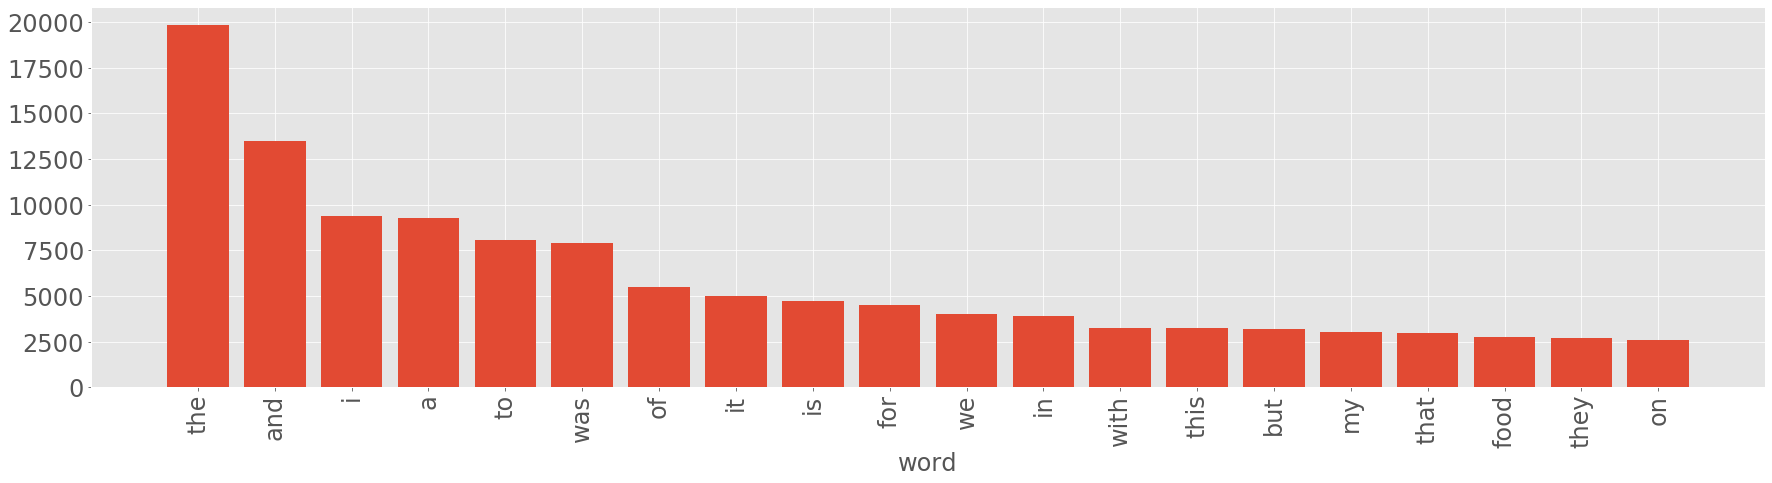

In [768]:
freqq = dict(zip(bow[:20], bow_counted[:20]))
plt.bar(freqq.keys(), freqq.values())
plt.xlabel('word', fontsize=24)
plt.xticks(fontsize=24, rotation=90)
plt.yticks(fontsize=24)

#### As can be seen, until the 18th most common word we found real meaning with "food" but before that, it is clear how the first 3 words don't really contribute with useful semantics

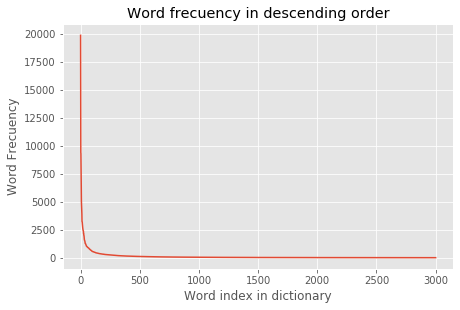

<Figure size 72x216 with 0 Axes>

In [782]:
fig = plt.figure(figsize=(7,4.5))
ax = fig.add_subplot(111)
plt.plot((np.linspace(0, len(bow_counted), num=len(bow_counted))), bow_counted)
plt.title("Word frecuency in descending order")
plt.xlabel("Word index in dictionary")
plt.ylabel("Word Frecuency")
plt.figure(figsize=(1,3))
plt.show()

On the previous graph, again can be seen the frecuency distribution of the words on the previously created BoW

#### A word cloud is created using the first 2000 most common words on the corpus, after removing a set of english stopwords commonly accepted in the literature

In [832]:
stopww = list(STOPWORDS)
stopww2 = []
for i in stopww:
    nn = i + "_not"
    stopww2.append(nn)
for i in stopww2:
    stopww.append(i)

In [834]:
word_dictionary_freq = dict(zip(bow, bow_counted))
for key, value in word_dictionary_freq.items():
    if key in stopww:
        word_dictionary_freq[key] = 0

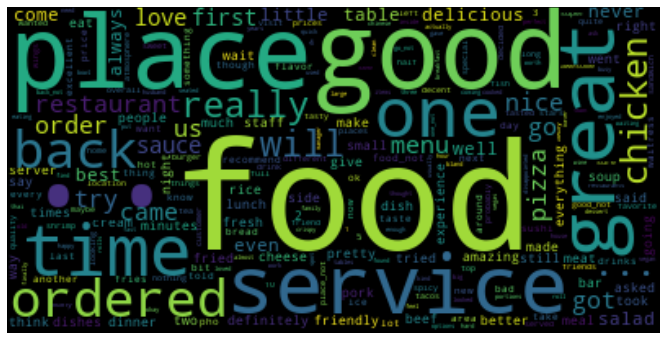

In [835]:
wc = WordCloud(max_words=2000, background_color="black", stopwords=stopww)
wc.generate_from_frequencies(word_dictionary_freq)
plt.imshow(wc, interpolation = "bilinear")
plt.axis("off")
plt.rcParams["figure.figsize"] = (26,6)
plt.show()

Several conclusions can be obtained from this word cloud:
* The data set is not balanced, we can see a lot of positive words representing big frecuencies
* Stopwords can also be "negatively anotated". e.g: *the_not, i_not, a_not*
* Words such as *chicken, food* indicate the existence of a domain specific corpus, and thus, classifier

In [394]:
'''
for word, numb in enumerate(zip(bow, bow_counted)):
    print(word, numb)
'''

'\nfor word, numb in enumerate(zip(bow, bow_counted)):\n    print(word, numb)\n'

In [342]:
def corpus_builder(raw_reviews, most_common):
    """
    Create the bag of words of all the words present on the reviews, ommiting the 'most_common' words as they are 
    conseidered as fillers with low influence on the classification
    -----------
    raw_reviews : all the column of the raw reviews
    most_common : list of most common words that wish to be ommited
    """
    main_corpus = []
    for review in raw_reviews:
        for word in review:
            if word in most_common:
                continue
            if word not in main_corpus:
                main_corpus.append(word)
    return main_corpus
#bow = corpus_builder(reviews, cc)
#len(bow)

In [343]:
def vectorizer(bow, ind_review, ommitted_words):
    """
    Vectorize the review based on the counting of the words present on the review, 
    the appereances are counted on a dictionary, the value of the words (keys) that are not present remain as '0'
    ----------
    bow : bag of all the words in list (unique values)
    ind_review = indiviual review to be vectorized
    ommited_words: number of most common words that are going to be ommited
    """
    ommitted = bow[:ommitted_words]
    bow = bow[ommitted_words:]
    counter = dict.fromkeys(bow, 0)
    for word in ind_review:
        try:
            if word in ommitted_words:
                continue
            else:
                counter[word] += 1
        except:
            pass
    return list(counter.values()), ommitted
#vv = vectorizer(bow, review1, cc)

In [344]:
def matrix_builder(bow, review_series, ommited_words):
    """
    Creates the matrix of features based on the term frecuency vectors created by the function vectorizer
    ----------
    bow: bag of words
    review_series : pandas object (series)  i.e dataframe[name_of_column]
    ommited_words: number of most common words that are going to be ommited
    """
    X = []
    i = 0
    
    for review in review_series:
        word_vector, ommitted = vectorizer(bow, review, ommited_words)
        if i < 1:
            X = np.array([word_vector])
            i += 1
            continue
        X = np.append(X, [word_vector], axis = 0)
    print(ommitted)
    return X

### Pipeline for the creation of the feature matrix
* features thus far: 
    * unigram i.e. word frecuency 

In [39]:
reviews = trial['tokens'].to_numpy()
common = most_common_words(reviews, 9)
bow = corpus_builder(reviews, common)
raw_reviews = trial['tokens']
X = matrix_builder(bow, raw_reviews, common)
X.shape

NameError: name 'counting' is not defined

## General Pipeline

1. Data
2. Tokens
3. Bow
3. Features (aka Matrix builder)
4. Classifiers

In [508]:
data2 = data.copy()
balance_sample(data2, 100)
tiktokens(data2)

1    100
0    100
Name: Sentiment, dtype: int64


In [483]:
features = data2['tokens'].to_numpy()
y = data2['Sentiment'].to_numpy()

In [476]:
#Construct the feature matrix (vectors)
common = 0
X = matrix_builder(bow, features, common)

[]


In [484]:
print(X.shape,"|||", y.shape)

(200, 3000) ||| (200,)


### From here start the classifier

* To start we are going to work only with unigrams, then we can add a lexicon to determine the sentiment score and use that as feature or also try with bigrams or somethign along those lines

In [485]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
clf = SVC(C = 1e-5, kernel = 'linear')

In [514]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33) 

In [506]:
clf.fit(X_train, y_train)

SVC(C=1e-05, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [517]:
clf.score(X_test, y_test)

0.48484848484848486

In [433]:
prediction = clf.predict(X_test)
accu = accuracy_score(y_test, prediction)

In [434]:
accu

0.49393939393939396

In [515]:
from sklearn.naive_bayes import MultinomialNB
clf2 = MultinomialNB()
clf2.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [516]:
clf2.score(X_test, y_test)

0.48484848484848486